# EMNIST handwritten digit and letter classifier

**Author: Lazar Galić**

The EMNIST dataset is an extension of the popular MNIST dataset. We will train a convolutional neural network to recognize handwritten letters and digits over a dataset.

The dataset is provided by the US National Institute of Standards and Technology (NIST) at the following link:

 - https://www.nist.gov/itl/products-and-services/emnist-dataset

The format is the same as the popular MNIST dataset, provided at the following link: 

 - http://yann.lecun.com/exdb/mnist/

## Data parsing

The dataset labels is provided as a set of 4 binary files in gzip libraries, and a textual mapping of classes to ASCII symbols:

 - _emnist-balanced-train-images-idx3-ubyte.gz_ - training input images
 - _emnist-balanced-train-labels-idx1-ubyte.gz_ - training output labels
 - _emnist-balanced-test-images-idx3-ubyte.gz_ - test input images
 - _emnist-balanced-test-labels-idx1-ubyte.gz_ - test output labels
 - _emnist-balanced-mapping.txt_ - class ID to ASCII map

Each of the four _.gz_ files is a simple IDX binary file used for storing values of $n$-dimensional matrices, zipped in a GZIP file. An $3$-dimensional matrix would be stored as follows:

```
  INDEX    HEXVALUE    EXPLANATION
  -----    --------    -----------
      0    00000803    Magical number

      4    0001B8A0    Length in dimension 1 [112800]
      8    0000001C    Length in dimension 2 [28]
     12    0000001C    Length in dimension 3 [28]
     
     16    ????????    Value of matrix field [0][0][0]
     20    ????????    Value of matrix field [0][0][1]
     24    ????????    Value of matrix field [0][0][2]
             ....
```

The "magical number" itself is comprised of 4 bytes. The first 2 bytes are always `00`, the third byte represents the data type (`08` for unsigned byte, used in MNIST), and the fourth byte represents the number of dimensions (e.g. `01` for vectors, `03` for 3D matrices).

Upon reading the files and loading the data into NumPy arrays, we will convert it to floating point numbers, and reshape it so that it is usable in the models, giving it a fourth dimension to represent the number of channels, which is 1 for the black and white input.

We will also load the class-character mapping to make the data easy to interpret by humans. This is stored in a textual file. It is given in the following format:

```
  LISTING    EXPLANATION
  -------    -----------
   X1 Y1     Class X1 corresponds to ASCII character Y1 (ord(Y1) in Python)
   X2 Y2     Class X2 corresponds to ASCII character Y2 (ord(Y2) in Python)
    ...
```

In [1]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
datapath = "./emnist-dataset/"

datafiles = {
    "train_input": "emnist-balanced-train-images-idx3-ubyte.gz",
    "train_labels": "emnist-balanced-train-labels-idx1-ubyte.gz",
    "test_input": "emnist-balanced-test-images-idx3-ubyte.gz",
    "test_labels": "emnist-balanced-test-labels-idx1-ubyte.gz",
    "map": "emnist-balanced-mapping.txt"
}

In [3]:
infile = gzip.open(datapath + datafiles['train_input'], 'r')

infile.read(4) # "Magic number"

imgc = int.from_bytes(infile.read(4), byteorder = 'big')
imgw = int.from_bytes(infile.read(4), byteorder = 'big')
imgh = int.from_bytes(infile.read(4), byteorder = 'big')

buf = infile.read(imgc * imgw * imgh)

Xtrn = np.frombuffer(buf, dtype = np.uint8).astype(np.float32)
Xtrn = Xtrn.reshape(imgc, imgw, imgh, 1)

infile.close()

In [4]:
Xtrn.shape

(112800, 28, 28, 1)

In [5]:
infile = gzip.open(datapath + datafiles['test_input'], 'r')

infile.read(4) # "Magic number"

imgc = int.from_bytes(infile.read(4), byteorder = 'big')
imgw = int.from_bytes(infile.read(4), byteorder = 'big')
imgh = int.from_bytes(infile.read(4), byteorder = 'big')

print(imgc, imgw, imgh)

buf = infile.read(imgc * imgw * imgh)

Xtst = np.frombuffer(buf, dtype = np.uint8).astype(np.float32)
Xtst = Xtst.reshape(imgc, imgw, imgh, 1)

infile.close()

18800 28 28


In [6]:
Xtst.shape

(18800, 28, 28, 1)

In [7]:
infile = gzip.open(datapath + datafiles['train_labels'], 'r')

infile.read(4) # "Magic number"

imgc = int.from_bytes(infile.read(4), byteorder = 'big')

buf = infile.read(imgc)

Ytrn = np.frombuffer(buf, dtype = np.uint8)
Ytrn = Ytrn.reshape(imgc)

infile.close()

In [8]:
Ytrn.shape

(112800,)

In [9]:
infile = gzip.open(datapath + datafiles['test_labels'], 'r')

infile.read(4) # "Magic number"

imgc = int.from_bytes(infile.read(4), byteorder = 'big')

buf = infile.read(imgc)

Ytst = np.frombuffer(buf, dtype = np.uint8)
Ytst = Ytst.reshape(imgc)

infile.close()

In [10]:
Ytst.shape

(18800,)

In [11]:
mapfile = open(datapath + datafiles['map'], 'r')

maplines = mapfile.readlines()

map = {}

for line in maplines:
  components = line.split()
  map[int(components[0])] = chr(int(components[1]))

catcount = len(map)

## Data preparation

Now, the data is provided mostly ready to be used. We only need to normalize the pixel values to be in the range $[0,1]$, as they currently fall within the range $[0,255]$, and to convert the single-number class labels into one-hot vectors.

Both of these operations should be fairly easy to implement using NumPy and TensorFlow.

In [14]:
imgshape = Xtrn.shape[1:]
print(imgshape)

(28, 28, 1)


In [15]:
nrmXtrn = Xtrn / 255
nrmXtst = Xtst / 255

catYtrn = tf.one_hot(Ytrn,catcount)
catYtst = tf.one_hot(Ytst,catcount)

## Data interpretation

We can write a function to easily display the character drawings using PyPlot, which we can then use to show the results and see the data.

In [63]:
def plotItem(Xs, Ys):
  count = len(Xs)
  
  pltcol = 4
  pltrow = (count - 1) // pltcol + 1

  for i in range(count):
    X = Xs[i]
    Y = Ys[i]

    X = X.reshape(imgw, imgh)

    plt.subplot(pltrow, pltcol, i+1)
    plt.tight_layout()
    plt.imshow(X.transpose(), cmap = 'Blues', interpolation = 'none')
    plt.title("Symbol {} = '{}'".format(Y, map[Y]))
    plt.xticks([])
    plt.yticks([])
  
  plt.figure()

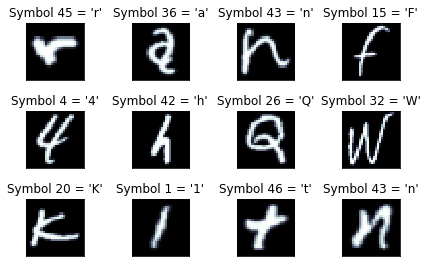

<Figure size 432x288 with 0 Axes>

In [64]:
plotItem(Xtrn[:12], Ytrn[:12])

## Model training

We can now set up a convolutional neural network to be trained on this dataset. Our aim is to use several layers of convolution to extract the features, combined with max-pooling layers to make decisions on the features, followed by several dense layers which perform classification, combined with dropout layers which prevent overfitting, offering sufficient width to store enough features to distinguish the 46 input classes, and sufficient depth to capture complex features, while taking into consideration the limited size of our dataset, and being careful to prevent overfitting.

I opted for the following structure:
  - _**First phase** - extracting basic, larger-scale features_
    - **Conv2D layer** with 32 output filters and a 5x5 kernel (ReLU activation, 'same' padding to preserve features on edges)
    - **Conv2D layer** with 48 output filters and a 5x5 kernel (ReLU activation, 'same' padding to preserve features on edges)
    - **MaxPool2D layer** with stride 2 - chooses 'more relevant' of the extracted low-level features
  - _**Second phase** - extracting deeper features_
    - **Conv2D layer** with 64 output filters and a 3x3 kernel (ReLU activation, 'same' padding to preserve features on edges)
    - **Conv2D layer** with 96 output filters and a 3x3 kernel (ReLU activation, 'same' padding to preserve features on edges)
    - **MaxPool2D layer** with stride 2
    - **Conv2D layer** with 128 output filters and a 3x3 kernel (ReLU activation)
    - **Conv2D layer** with 192 output filters and a 3x3 kernel (ReLU activation)
    - **MaxPool2D layer** with stride 2
  - _**Third phase** - classifying extracted features_
    - **Dropout layer** with rate 0.25 - sets 1/4 of the features to 0 randomly during training to prevent overfitting
    - **Flatten layer** removes the 4-th dimension from the dataset to prepare the data for classification
    - **Dense layer** with 512 nodes is the first level of classification
    - **Dropout layer** with rate 0.25
    - **Dense layer** with 256 nodes
    - **Dropout layer** with rate 0.25
    - **Dense layer** with 128 nodes
    - **Dropout layer** with rate 0.25
    - **Dense layer** with catcount=46 nodes to give the final likelihoods of the input belonging to a specific output class, with softmax applied to boost the likelihoods of the more likely outcomes.

In [54]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(
        32, (5,5), 
        activation = 'relu',
        padding = 'same',
        input_shape = imgshape
    ),
    tf.keras.layers.Conv2D(
        48, (5,5), 
        activation = 'relu', 
        padding = 'same'
    ),
    tf.keras.layers.MaxPool2D(
        strides = (2,2)
    ),
    tf.keras.layers.Conv2D(
        64, (3,3), 
        activation = 'relu', 
        padding = 'same'
    ),
    tf.keras.layers.Conv2D(
        96, (3,3), 
        activation = 'relu', 
        padding = 'same'
    ),
    tf.keras.layers.MaxPool2D(
        strides = (2,2)
    ),
    tf.keras.layers.Conv2D(
        128, (3,3), 
        activation = 'relu'
    ),
    tf.keras.layers.Conv2D(
        192, (3,3), 
        activation = 'relu'
    ),
    tf.keras.layers.Conv2D(
        256, (3,3), 
        activation = 'relu'
    ),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(
        512, 
        activation = 'relu'
    ),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(
        256, 
        activation = 'relu'
    ),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(
        128, 
        activation = 'relu'
    ),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(
        catcount, 
        activation = 'softmax'
    )
])

In [55]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0008), 
    loss = tf.keras.metrics.categorical_crossentropy, 
    metrics = [ 'acc' ]
)

In [56]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 28, 28, 48)        38448     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 48)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 14, 14, 64)        27712     
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 14, 14, 96)        55392     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 7, 7, 96)          0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 5, 5, 128)        

In [57]:
escb = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_acc',
    min_delta = 0,
    patience = 1,
    verbose = 1,
    restore_best_weights = True
)

In [58]:
batchsize = 64
epochs = 30
model_log = model.fit(
    nrmXtrn, catYtrn, 
    batch_size = batchsize, 
    epochs = epochs, 
    verbose = 1, 
    validation_data = (nrmXtst, catYtst),
    callbacks = [ escb ]
)

Epoch 1/30
1763/1763 [==============================] - 683s 387ms/step - loss: 1.2872 - acc: 0.6159 - val_loss: 0.4530 - val_acc: 0.8508
Epoch 2/30
1763/1763 [==============================] - 548s 311ms/step - loss: 0.4907 - acc: 0.8466 - val_loss: 0.4159 - val_acc: 0.8615
Epoch 3/30
1763/1763 [==============================] - 411s 233ms/step - loss: 0.4221 - acc: 0.8649 - val_loss: 0.3964 - val_acc: 0.8711
Epoch 4/30
1763/1763 [==============================] - 416s 236ms/step - loss: 0.3894 - acc: 0.8733 - val_loss: 0.3648 - val_acc: 0.8789
Epoch 5/30
1763/1763 [==============================] - 527s 299ms/step - loss: 0.3593 - acc: 0.8812 - val_loss: 0.3486 - val_acc: 0.8819
Epoch 6/30
1763/1763 [==============================] - 708s 402ms/step - loss: 0.3415 - acc: 0.8859 - val_loss: 0.3984 - val_acc: 0.8747
Restoring model weights from the end of the best epoch.
Epoch 00006: early stopping


In [59]:
score = model.evaluate(nrmXtst, catYtst, verbose=0)
print("Test loss: {}".format(score[0]))
print("Test accuracy: {}".format(score[1]))

Test loss: 0.3485581576824188
Test accuracy: 0.881861686706543


## Model usage

We got **88.19%** accuracy, which is a solid result for classifying into 46 classes, given the limited size of our dataset.

We can now store the model into a hierarchical data format HDF5 file, so that we can examine or use it later.

In [60]:
model_file_name = "model-" + str(int(score[0]*(10**6))) + "-" + str(int(score[1]*(10**6)))

model_digit_json = model.to_json()
with open(model_file_name + ".json", "w") as json_file:
  json_file.write(model_digit_json)
model.save(model_file_name + ".h5")
print("Saved model to disk")

Saved model to disk


In [61]:
loaded_model = tf.keras.models.load_model(model_file_name + ".h5")

In [62]:
loaded_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 28, 28, 48)        38448     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 48)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 14, 14, 64)        27712     
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 14, 14, 96)        55392     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 7, 7, 96)          0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 5, 5, 128)        